In [1]:
# TCC: APLICAÇÃO DE MACHINE LEARNING PARA APOSTAS ESPORTIVAS: uso de Regressão Logística,
#      SVM, Árvore de Decisão e Naive Bayes
#
# Aluno: João Henrique
# Orientadora: Renata Alcoforado

In [2]:
# Importando as bibliotecas

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score , f1_score, precision_score, recall_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import  GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
%matplotlib inline

In [3]:
# O arquivo utilizado foi uma compilação com dados baixados do site www.football-data.co.uk, que disponibiliza...
# ... informações de diversos campeonatos ao redor do mundo
# Por meio do Excel foram retirados os jogos em que estavam faltando dados de quaisquer variáveis de interesse...
# ...para o estudo


# Legenda das variáveis:

# Div = Divisão da Liga
# Date = Data do jogo
# HomeTeam = Time da casa
# AwayTeam = Time visitante
# FTR = Resultado do jogo (0 = empate, 1 = vitória do time da casa, 2 = vitória do time visitante)
# B365H = Odd (probablidade) de vitória do time da casa pela Bet365 (casa de apostas)
# B365D = Odd (probablidade) de empate pela Bet365 (casa de apostas)
# B365A = Odd (probablidade) de vitória do time visitante pela Bet365 (casa de apostas)
# BWH = Odd (probablidade) de vitória do time da casa pela Bet&Win (casa de apostas)
# BWD = Odd (probablidade) de empate pela Bet&Win (casa de apostas)
# BWA = Odd (probablidade) de vitória do time visitante pela Bet&Win (casa de apostas)
# IWH = Odd (probablidade) de vitória do time da casa pela Interwetten (casa de apostas)
# IWD = Odd (probablidade) de empate pela Interwetten (casa de apostas)
# IWA = Odd (probablidade) de vitória do time visitante pela Interwetten (casa de apostas)
# PSH = Odd (probablidade) de vitória do time da casa pela Pinnacle (casa de apostas)
# PSD = Odd (probablidade) de empate pela Pinnacle (casa de apostas)
# PSA = Odd (probablidade) de vitória do time visitante pela Pinnacle (casa de apostas)
# VCH = Odd (probablidade) de vitória do time da casa pela VC Bet (casa de apostas)
# VCD = Odd (probablidade) de empate pela VC Bet (casa de apostas)
# VCA = Odd (probablidade) de vitória do time visitante pela VC Bet (casa de apostas)
# WHH = Odd (probablidade) de vitória do time da casa pela William Hill (casa de apostas)
# WHD = Odd (probablidade) de empate pela William Hill (casa de apostas)
# WHA = Odd (probablidade) de vitória do time visitante pela William Hill (casa de apostas)

# Lendo o arquivo ENG10anos.csv
data = pd.read_csv('ENG10anos.csv', delimiter = ',')

# Visualizando a base de dados:
display(data.head())

,Div,Date,HomeTeam,AwayTeam,FTR,B365H,B365D,B365A,BWH,BWD,...,IWA,PSH,PSD,PSA,VCH,VCD,VCA,WHH,WHD,WHA
0,E0,18/08/12,Arsenal,Sunderland,D,1.40,4.50,8.50,1.35,4.6,...,7.3,1.44,4.76,8.78,1.44,4.75,8.50,1.44,4.0,8.0
1,E0,18/08/12,Fulham,Norwich,H,1.80,3.60,4.50,1.80,3.5,...,4.0,1.82,3.81,4.80,1.83,3.75,4.75,1.85,3.3,4.5
2,E0,18/08/12,Newcastle,Tottenham,H,2.50,3.40,2.75,2.60,3.3,...,2.7,2.65,3.47,2.82,2.62,3.40,2.75,2.70,3.0,2.8
3,E0,18/08/12,QPR,Swansea,A,2.00,3.40,3.80,2.00,3.4,...,3.1,2.05,3.53,4.01,2.00,3.50,4.00,2.00,3.3,3.8
4,E0,18/08/12,Reading,Stoke,D,2.38,3.25,3.10,2.40,3.2,...,2.7,2.40,3.37,3.26,2.40,3.30,3.25,2.40,3.3,2.9


In [4]:
# Criando a coluna com o identificador do jogo (Game_id)

data = pd.DataFrame(data)
data = data.reset_index()
data = data.rename(columns = {"index": "Game_id"})
data["Game_id"] = data.index + 1


# Alterando os resultados de string (D = empate, H = vitória do time da casa, A = vitória do time visitante), para
# int (0 = empate, 1 = vitória do time da casa, 2 = vitória do time visitante)
for i in range(0,len(data)):
    if data["FTR"][i] == "D":
        data.at[i,"FTR"] = "0"
    if data["FTR"][i] == "H":
        data.at[i,"FTR"] = "1"
    if data["FTR"][i] == "A":
        data.at[i,"FTR"] = "2"

data["FTR"] = data["FTR"].astype(str).astype(int)

# Verificando as 5 primeiras linhas do arquivo após os primeiros ajustes
display(data.head())

,Game_id,Div,Date,HomeTeam,AwayTeam,FTR,B365H,B365D,B365A,BWH,...,IWA,PSH,PSD,PSA,VCH,VCD,VCA,WHH,WHD,WHA
0,1,E0,18/08/12,Arsenal,Sunderland,0,1.40,4.50,8.50,1.35,...,7.3,1.44,4.76,8.78,1.44,4.75,8.50,1.44,4.0,8.0
1,2,E0,18/08/12,Fulham,Norwich,1,1.80,3.60,4.50,1.80,...,4.0,1.82,3.81,4.80,1.83,3.75,4.75,1.85,3.3,4.5
2,3,E0,18/08/12,Newcastle,Tottenham,1,2.50,3.40,2.75,2.60,...,2.7,2.65,3.47,2.82,2.62,3.40,2.75,2.70,3.0,2.8
3,4,E0,18/08/12,QPR,Swansea,2,2.00,3.40,3.80,2.00,...,3.1,2.05,3.53,4.01,2.00,3.50,4.00,2.00,3.3,3.8
4,5,E0,18/08/12,Reading,Stoke,0,2.38,3.25,3.10,2.40,...,2.7,2.40,3.37,3.26,2.40,3.30,3.25,2.40,3.3,2.9


Total de jogos:  3798
Total de colunas:  24
Total de jogos ganhos em casa:  1694
Total de jogos ganhos pelo visitante:  1201
Total de jogos empatados:  903
Percentual de jogos ganhos em casa: 44.60%


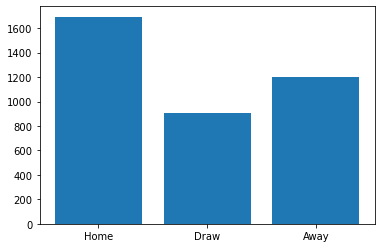

In [5]:
# Explorando a base de dados de dos campeonatos de 2012/2013 a 2021/2022 (últimas 10 temporadas completas)

# Obs.: 2 linhas da base de dados foram retiradas por falta de algumas informações necessárias de variáveis

matches = data.shape[0]
features = data.shape[1]

home_win = len(data[data.FTR==1])
away_win = len(data[data.FTR==2])
draw = len(data[data.FTR==0])
val = [home_win, draw, away_win]

win_rate = (float(home_win)/(matches)) *100

print ('Total de jogos: ', matches)
print ('Total de colunas: ', features)
print ('Total de jogos ganhos em casa: ', home_win)
print ('Total de jogos ganhos pelo visitante: ', away_win)
print ('Total de jogos empatados: ', draw)
print ('Percentual de jogos ganhos em casa: {:.2f}%'.format( win_rate ))

x = np.arange(3)
plt.bar(x, val)
plt.xticks(x, ('Home', 'Draw', 'Away'))
plt.show()

In [6]:
# Separando as features e as labels

features = data[['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'VCH', 'VCD', 'VCA', 'WHH', 'WHD', 'WHA']]
labels = data['FTR']

print('Features')
print(features.head())
print('=====================')
print('Labels')
print(labels.head())

Features
   B365H  B365D  B365A   BWH  BWD   BWA   IWH  IWD  IWA   PSH   PSD   PSA  \
0   1.40   4.50   8.50  1.35  4.6  9.00  1.35  4.5  7.3  1.44  4.76  8.78   
1   1.80   3.60   4.50  1.80  3.5  4.40  1.80  3.4  4.0  1.82  3.81  4.80   
2   2.50   3.40   2.75  2.60  3.3  2.75  2.40  3.2  2.7  2.65  3.47  2.82   
3   2.00   3.40   3.80  2.00  3.4  3.60  2.10  3.3  3.1  2.05  3.53  4.01   
4   2.38   3.25   3.10  2.40  3.2  3.10  2.40  3.2  2.7  2.40  3.37  3.26   

    VCH   VCD   VCA   WHH  WHD  WHA  
0  1.44  4.75  8.50  1.44  4.0  8.0  
1  1.83  3.75  4.75  1.85  3.3  4.5  
2  2.62  3.40  2.75  2.70  3.0  2.8  
3  2.00  3.50  4.00  2.00  3.3  3.8  
4  2.40  3.30  3.25  2.40  3.3  2.9  
Labels
0    0
1    1
2    1
3    2
4    0
Name: FTR, dtype: int32


In [7]:
# Normalizando os dados de entrada (features)

scaler = MinMaxScaler().fit(features)
features_scale = scaler.transform(features)

print('Features: ',features_scale.shape)
print(features_scale)

Features:  (3798, 18)
[[0.01549681 0.11971831 0.18505517 ... 0.01954887 0.09836066 0.15329768]
 [0.03372835 0.05633803 0.08475426 ... 0.04010025 0.04098361 0.07531194]
 [0.06563355 0.04225352 0.04087262 ... 0.08270677 0.01639344 0.03743316]
 ...
 [0.00364631 0.40140845 0.34804413 ... 0.00501253 0.3442623  0.39839572]
 [0.00455789 0.36619718 0.39819458 ... 0.00501253 0.3442623  0.39839572]
 [0.38468551 0.26056338 0.00325978 ... 0.44862155 0.26229508 0.00289661]]


In [8]:
# Separação de treino e teste, feita manualmente para manter a ordem cronológica, uma vez que...
# ... temos informação temporal.
# Treino [:3040]     representa 80% dos dados
# Teste [3040:3420]      representa 10% dos dados
# Previsão [3040:3798]     representa 10% dos dados


X_train = features_scale[:3040]
X_test = features_scale[3040:3420]
y_train = labels[:3040]
y_test = labels[3040:3420]

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

3040 3040
380 380


In [9]:
# Rodando o modelo de Regressão Logística em sua versão multinomial

clf_LR = LogisticRegression(multi_class = 'multinomial', max_iter = 2000)
clf_LR.fit(X_train, y_train)
pred = clf_LR.predict(X_test)

lr_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'micro')

print('Regressão Logística')
print('')
print('Acurácia: {:.2f}%'.format(lr_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

Regressão Logística

Acurácia: 49.74%
F1 Score: 49.74%


In [10]:
# Rodando o modelo de Support Vector Machine (SVM)

clf_SVM = SVC()
clf_SVM.fit(X_train, y_train)
pred = clf_SVM.predict(X_test)

svm_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'micro')

print('SVM')
print('')
print('Acurácia: {:.2f}%'.format(svm_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

SVM

Acurácia: 49.47%
F1 Score: 49.47%


In [11]:
# Rodando o modelo de Árvore de Decisão

clf_DT = DecisionTreeClassifier(random_state=42)
clf_DT.fit(X_train, y_train)
pred = clf_DT.predict(X_test)

dt_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'macro')

print('Árvore de Decisão')
print('')
print('Acurácia: {:.2f}%'.format(dt_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

Árvore de Decisão

Acurácia: 40.26%
F1 Score: 37.26%


In [12]:
# Rodando o modelo de Naive Bayes

clf_NB = GaussianNB()
clf_NB.fit(X_train, y_train)
pred = clf_NB.predict(X_test)

nb_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'micro')

print('Naive Bayes')
print('')
print('Acurácia Naive Bayes: {:.2f}%'.format(nb_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

Naive Bayes

Acurácia Naive Bayes: 38.16%
F1 Score: 38.16%


In [13]:
#Executando a previsão pelo método de maior acurácia (Regressão Logística)

previsao = features_scale[3420:]

game_id_full = data['Game_id']
game_id_prev = game_id_full[3420:]

res_full = data['FTR']
res_prev = res_full[3420:]

pred = clf_LR.predict(previsao)

df = pd.DataFrame({'Real': res_prev, 'Previsão': pred, 'Game_id': game_id_prev})

print(df)

      Real  Previsão  Game_id
3420     2         2     3421
3421     1         1     3422
3422     1         1     3423
3423     1         1     3424
3424     1         2     3425
...    ...       ...      ...
3793     1         2     3794
3794     1         1     3795
3795     1         1     3796
3796     1         1     3797
3797     2         2     3798

[378 rows x 3 columns]


<AxesSubplot:xlabel='Previsão', ylabel='Real'>

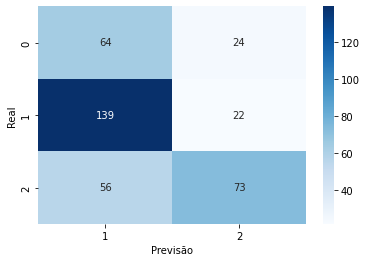

In [14]:
#confusion Matrix

df = pd.DataFrame(df,columns = ['Real','Previsão'])

cf_matrix = pd.crosstab(df['Real'], df['Previsão'], rownames = ['Real'] , colnames = ['Previsão'])

sns.heatmap(cf_matrix, annot = True, cmap = 'Blues', fmt = 'g')